In [1]:
import pandas as pd
import numpy as np
import plotly.express as px # For colors
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
l_cols=['time_run', 's_uptime', 'cpu_l5min', 'tmra_files', 'tmra_sess', 'tmra_term', 'counter']
df = pd.read_csv('/opt/vm-auto-shutdown/data/variable_history.csv', 
                 names=l_cols, header=None, na_values=['None'])
df.shape

(765, 7)

In [3]:
# Post-processing :

df['utc_datetime_run'] = pd.to_datetime(df.time_run, unit='s')
# 'sMRA' = 'Seconds since Most Recent Activity'
df['smra_files'] = df.time_run - df.tmra_files
df['smra_sess']  = df.time_run - df.tmra_sess
df['smra_term']  = df.time_run - df.tmra_term

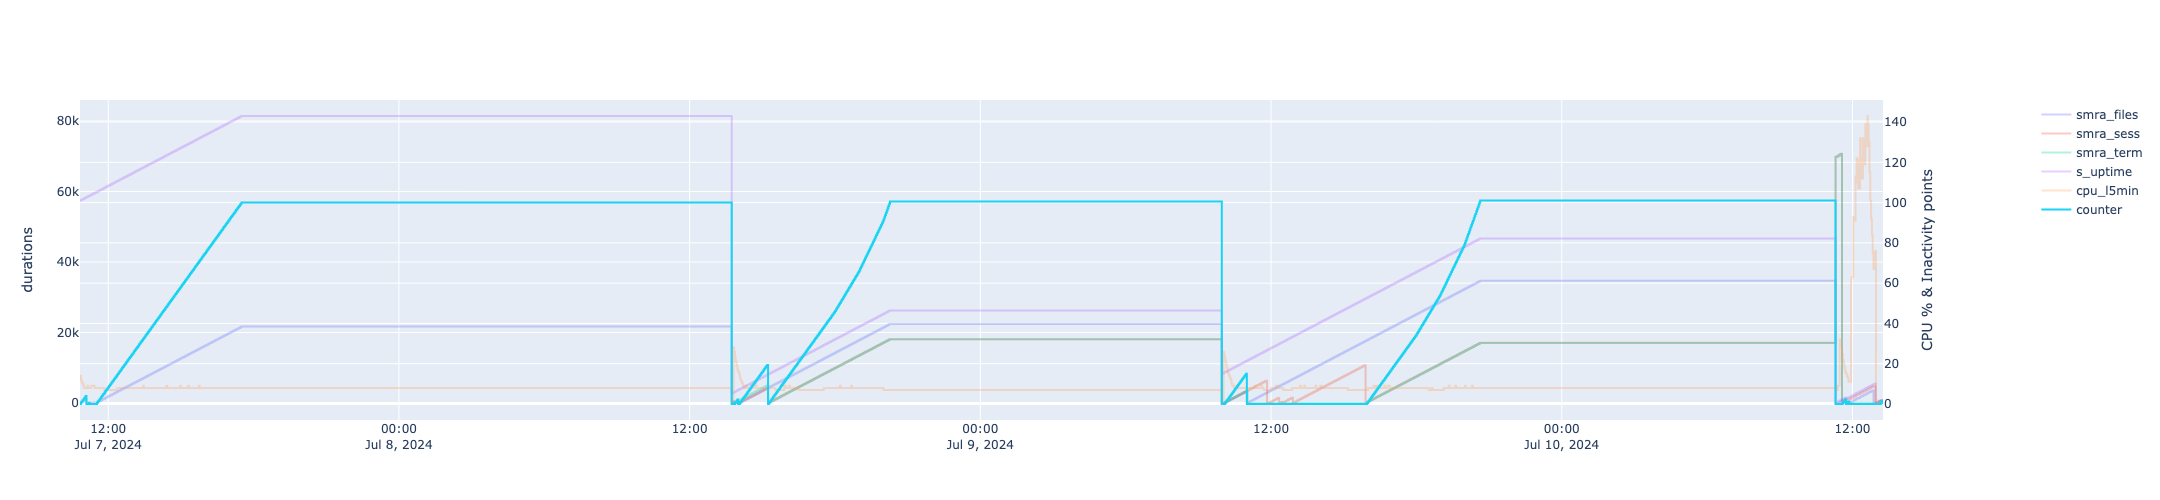

In [5]:
# Plot :

fig = make_subplots(specs=[[{"secondary_y": True}]])

def _trace(col_name, secondary_y, k=1, opacity=.3) :
    fig.add_trace(
        go.Scatter(x=df['utc_datetime_run'], y=k*df[col_name], name=col_name, opacity=opacity, line_shape='hv'),
        secondary_y=secondary_y
    ) 
[_trace(col_name, False) for col_name in ['smra_files', 'smra_sess', 'smra_term', 's_uptime']]
_trace('cpu_l5min', True, 100)
_trace('counter', True, opacity=1.)
    
# Set y-axes titles
fig.update_yaxes(title_text='durations', secondary_y=False)
fig.update_yaxes(title_text='CPU % & Inactivity points', secondary_y=True)
fig.update_layout(height=500)
fig.show()

# Legacy code :

In [19]:
# fig = make_subplots(specs=[[{"secondary_y": True}]])
# 
# L_COLORS = px.colors.qualitative.Plotly
# i_color = 0
# 
# def line_and_markers(col_name, color, secondary_y, fun_format=lambda s:s) :
#     s_y = fun_format(df[col_name])
#     fig.add_trace(
#         go.Scatter(x=df['utc_datetime_run'], y=s_y, name=col_name, 
#                    line_color=color, opacity=.3),
#         secondary_y=secondary_y,
#     )
#     # mask = df[col_name].map(lambda v: is_active(col_name, v))
#     # fig.add_trace(
#     #     go.Scatter(x=df.loc[mask,'utc_datetime_run'], y=s_y.loc[mask], name=f'{col_name} (active)',
#     #                marker_color=color, mode='markers', marker=dict(size=4)),
#     #     secondary_y=secondary_y,
#     # )
# 
# for col_name in ['smra_files', 'smra_sess', 'smra_term', 's_uptime'] :
#     line_and_markers(col_name, L_COLORS[i_color], False, lambda s: pd.to_datetime(s, unit='s'))
#     i_color += 1
# line_and_markers('cpu_l5min', L_COLORS[i_color], True, lambda s:100*s)
# i_color += 1
# fig.add_trace(
#     go.Scatter(x=df['utc_datetime_run'], y=df['counter'], name='counter', 
#                line_color=L_COLORS[i_color], opacity=.3),
#     secondary_y=True
# )
# 
# 
# # Set y-axes titles
# fig.update_yaxes(title_text='durations', secondary_y=False)
# fig.update_yaxes(title_text='CPU % & Inactivity points', secondary_y=True)
# fig.update_layout(height=500)
# fig.show()

In [9]:
# function is_jup_active() { # (curr, prv) -> bool
#     [ -z "$2" ] && return $(false)  # Previous empty -> no reason to think we're active...
#     cond "( $1>$2 && ($1-$2)<12*60 ) || ($1-$2)>60*60" && return $(true) # "new HTTP" AND "Not a 15min beacon"
#     false
# }
# function is_active() { # () -> bool
#     log "is_active()..."
#     cond "$s_uptime < $time_run - $p_time_run" && log 'Machine rebooted' && return $(true) # p_ = previous_
#     cond "$cpu_l5min > .25" && log 'CPU high' && return $(true)
#     cond "$tmra_files > $p_tmra_files" && log 'Modified file' && return $(true)
#     is_jup_active "$tmra_sess" "$p_tmra_sess" && log 'New Jup Sess Activity' && return $(true)
#     is_jup_active "$tmra_term" "$p_tmra_term" && log 'New Jup Term Activity' && return $(true)
#     false # Else, not active 
# }

# Just used for flagging points on the graph 
def is_active(col_name, value) :
    if col_name in ['smra_files', 'smra_sess', 'smra_term', 's_uptime'] :
        return value < 2*60
    elif col_name == 'cpu_l5min' :
        return value > .25

In [ ]:
# -----------------------------> time
#    ^           ^          ^
# activity    activity     run
#    <-----------><--------->
#          d2         d1

In [ ]:
if d1 > period + eps :
    # If no signal during the period... then definitely NOT active
    return False
if d2 in [10min, 20min] :
    # If a signal during the period, but signal seems suspiciously periodical... 
    # We consider it to be FAKE activity (beacon)
    return False
return True

In [32]:

    # else return None :)
    
# These are the timeout_duration "x" ==> "At this rate, it would take x hours to shutdown the machine"
# We will cumulate by the INVERT (1/x) of this duration. We keep duration here for easier interpretation.
# Time in Switzerland :  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0,  1
# Time in UTC         :  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23
L_TIMEOUT_BY_UTC_HOUR = [1,  1,  1,  1,  1,  1,  3,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  5,  4,  3,  2,  2, 1]

PERIOD_EXECUTION = 2

In [38]:
df['utc_datetime_run']

0      2024-07-01 14:37:15
1      2024-07-01 14:40:49
2      2024-07-01 14:45:33
3      2024-07-01 14:51:17
4      2024-07-01 14:56:25
               ...        
996    2024-07-05 10:20:14
997    2024-07-05 10:25:29
998    2024-07-05 10:30:13
999    2024-07-05 10:35:34
1000   2024-07-05 10:40:43
Name: utc_datetime_run, Length: 1001, dtype: datetime64[ns]

In [33]:
l = []
p=0
for _,r in df.iterrows() :
    if any(
        is_active(col_name, r[col_name])
        for col_name in ['smra_files', 'smra_sess', 'smra_term', 's_uptime', 'cpu_l5min']) :
        p=0
    else :
        p+= 1/L_TIMEOUT_BY_UTC_HOUR[r['utc_datetime_run'].hour]
    l.append(p)
df['counter'] = l

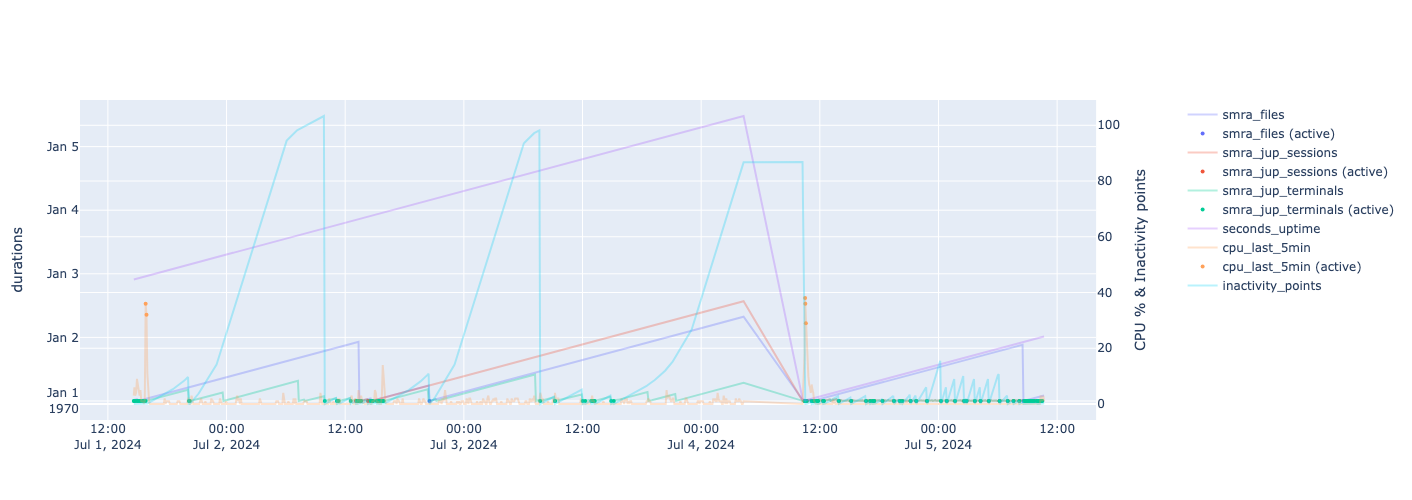

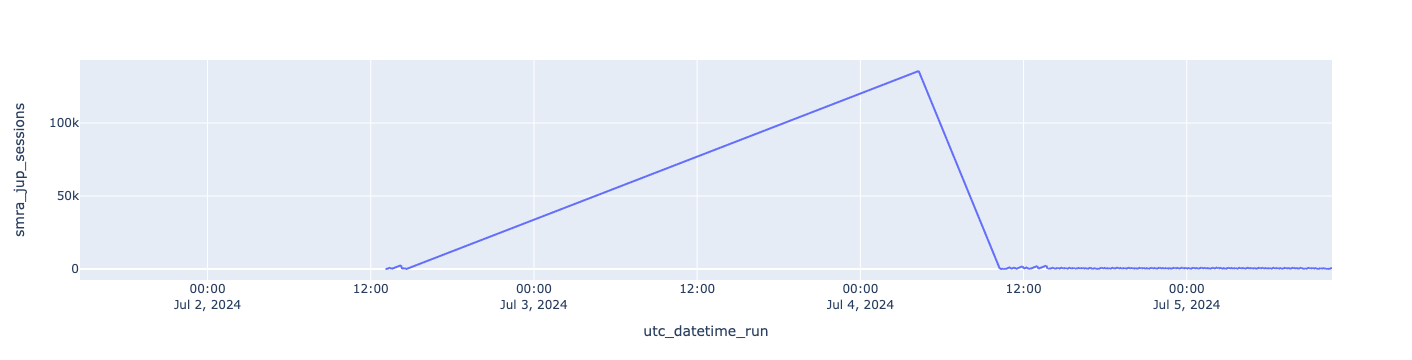

In [36]:
px.line(df, x='utc_datetime_run', y='smra_sess')

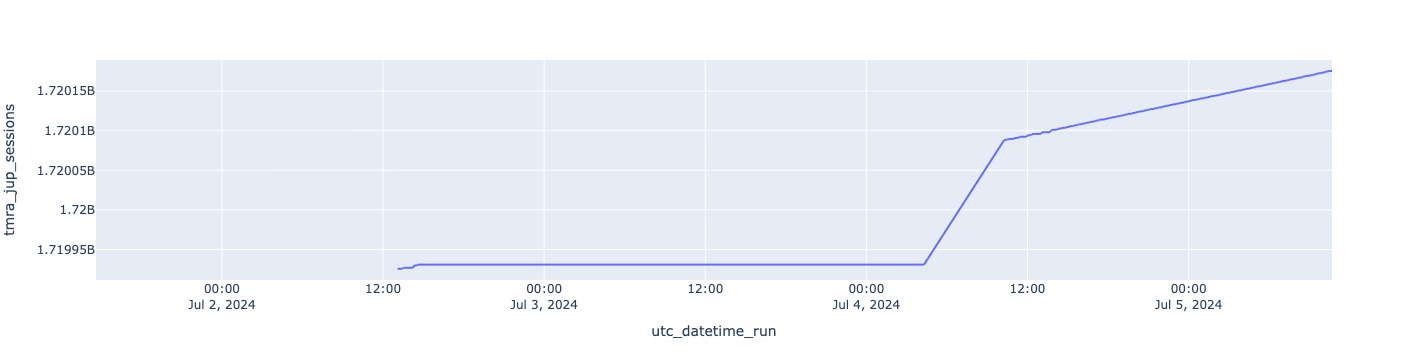

In [37]:
px.line(df, x='utc_datetime_run', y='tmra_sess')